# Load parameters

In [1]:
# Parameters loaded below

In [2]:
# Parameters
SAMPLE = "VIB_10xv1_1"
BARCARD_OVERLAP_TSV = "VIB_10xv1_1.barcard.overlap.tsv"


In [3]:
sample = SAMPLE
file = BARCARD_OVERLAP_TSV
print(sample)
print(file)

VIB_10xv1_1
VIB_10xv1_1.barcard.overlap.tsv


# Import libraries and define functions

In [4]:
import os
import pandas as pd
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import numpy as np

In [5]:
def histogram(array, nbins=100):
    """
    Draw histogram from distribution and identify centers.
    Parameters
    ---------
    array: `class::np.array`
            Scores distribution
    nbins: int
            Number of bins to use in the histogram
    Return
    ---------
    float
            Histogram values and bin centers.
    """
    array = array.ravel().flatten()
    hist, bin_edges = np.histogram(array, bins=nbins, range=None)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    return hist, bin_centers


def threshold_otsu(array, nbins=100):
    """
    Apply Otsu threshold on topic-region distributions [Otsu, 1979].
    Parameters
    ---------
    array: `class::np.array`
            Array containing the region values for the topic to be binarized.
    nbins: int
            Number of bins to use in the binarization histogram
    Return
    ---------
    float
            Binarization threshold.
    Reference
    ---------
    Otsu, N., 1979. A threshold selection method from gray-level histograms. IEEE transactions on systems, man, and
    cybernetics, 9(1), pp.62-66.
    """
    hist, bin_centers = histogram(array, nbins)
    hist = hist.astype(float)
    # Class probabilities for all possible thresholds
    weight1 = np.cumsum(hist)
    weight2 = np.cumsum(hist[::-1])[::-1]
    # Class means for all possible thresholds
    mean1 = np.cumsum(hist * bin_centers) / weight1
    mean2 = (np.cumsum((hist * bin_centers)[::-1]) / weight2[::-1])[::-1]
    # Clip ends to align class 1 and class 2 variables:
    # The last value of ``weight1``/``mean1`` should pair with zero values in
    # ``weight2``/``mean2``, which do not exist.
    variance12 = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
    idx = np.argmax(variance12)
    threshold = bin_centers[:-1][idx]
    return threshold

# Calculate threshold

VIB_10xv1_1


	threshold: 0.05391259332120002
	npairs_merged: 249


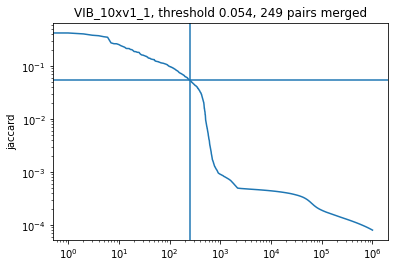

In [6]:
threshold_min = 0.02

print(sample)
df = pd.read_csv(file, header=0, sep="\t")

df = df.sort_values(by="jaccard", ascending=False)[:1000000]
df.reset_index(inplace=True, drop=True)

threshold = threshold_otsu(df["jaccard"])
if threshold < 0.02:
    threshold = threshold_min
threshold_rank = sum(df["jaccard"] > threshold)

print(f"\tthreshold: {threshold}")
print(f"\tnpairs_merged: {threshold_rank}")

f, ax = plt.subplots(1, 1)
sns.lineplot(data=df, x=range(len(df)), y="jaccard", ax=ax)
ax.axhline(y=threshold, xmin=0, xmax=10000000)
ax.axvline(x=threshold_rank, ymin=0.0001, ymax=1)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title(sample)
ax.set_title(
    f"{sample}, threshold {round(threshold, 3)}, {threshold_rank} pairs merged"
)
plt.savefig(
    f"{sample}.barcard_kneeplot.png",
    dpi=300,
    facecolor="white",
)
plt.show()
df.iloc[:threshold_rank].to_csv(
    f"{sample}.barcard.overlap.otsu_filtered.tsv", sep="\t", index=False
)

# VSN Pipelines: BAP multiplet pipeline report

Additional analyses and plots from the output of BAP (https://github.com/caleblareau/bap)

import pandas as pd
import numpy as np
import os
from collections import Counter
import itertools
import json

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

params = json.loads(WORKFLOW_PARAMETERS)

print(f"SAMPLE: {SAMPLE}")
print(f"BAP Parameters: {json.dumps(params, indent=4)}")

# read in data
f_bap_qc = SAMPLE+'.implicatedBarcodes.csv.gz'
f_bap_bct = SAMPLE+'.barcodeTranslate.tsv'
f_bap_nc = SAMPLE+'.NCsumstats.tsv'

bap_ib = pd.read_csv(f_bap_qc)
bap_bct = pd.read_csv(f_bap_bct, sep='\t', header=None, names=['barcode','bap_barcode'])
bap_nc = pd.read_csv(f_bap_nc, sep='\t')

## Overlap index

Plot the overlap scores, representing the pairwise similarity between each barcode.

# overlap index rank plot
def plot_overlap_rankplot(dat, label, ax):
    y = dat['jaccard_frag'].sort_values(ascending=False)
    ix = dat['jaccard_frag'][ dat['merged']==True ].idxmin()
    thr = dat.iloc[ix]['jaccard_frag']
    thrx = sum(dat['merged']==True)
    
    ax.scatter(x=range(y.shape[0]),
               y=y.values,
               s=4,
               edgecolors=None)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel('Jaccard index per barcode pair')
    ax.set_xlabel('Barcode pair rank')
    ax.axhline(thr, color='grey', linestyle='--')
    ax.text(0.01, 0.01, f" thr={round(thr,4)} ({thrx} barcode pairs)", ha='left', va='bottom' , transform=ax.transAxes, fontsize='x-small')
    ax.set_title(label)

fig, ax = plt.subplots(1,1, figsize=(5,4), dpi=150 )

plot_overlap_rankplot(bap_ib, label=SAMPLE, ax=ax)
plt.tight_layout()

## Calculate restricted longest common subsequence (rLCS)

This approach follows the methods in:
* Lareau, C. A., Ma, S., Duarte, F. M. & Buenrostro, J. D. Inference and effects of barcode multiplets in droplet-based single-cell assays. Nature Communications 11, 1–9 (2020). https://doi.org/10.1038/s41467-020-14667-5

This is calculated by taking each set of barcodes identified as a multiplet, and calculating the overlap
and identifies two groups of droplet multiplets:
* **Physical multiplets** (multiple beads that are physically grouped together in a droplet)
  * Contains uniform barcodes (less than cutoff threshold on rLCS)
* **Complex beads** (assumed to be due to bead barcode synthesis errors)
  * Contain heterogenous barcodes (greater than a cutoff threshold on rLCS)

# calculate rLCS match score
def barcode_rle(a, b):
    assert len(a) == len(b)
    match_cnt = 0
    match_list = []
    for i in range(len(a)):
        
        if(a[i] == b[i]):
            match_cnt += 1
        else:
            match_list.append(match_cnt)
            match_cnt = 0
    match_list.append(match_cnt)
    return max(match_list)

rLCS_thr = 6

bap_bct['bap_N'] = [ x.split('_')[-1] for x in bap_bct['bap_barcode'] ]

multiplets = pd.DataFrame(
    bap_bct['bap_barcode'][bap_bct['bap_N']!='N01'].unique(), 
    columns=['bap_barcode'])
multiplets['bap_N'] = [ x.split('_')[-1] for x in multiplets['bap_barcode'] ]

bcs_scores = []
for i,m in enumerate(multiplets['bap_barcode']):
    bcs = bap_bct['barcode'][bap_bct['bap_barcode']==m]
    bcs_comb = list(itertools.combinations(bcs, 2))
    mean_scores = np.mean([ barcode_rle(x[0], x[1]) for x in bcs_comb ])
    bcs_scores.append(mean_scores)
multiplets['mean_rLCS'] = bcs_scores

# classify multiplet similarity by threshold
multiplets['multiplets_passing_rLCS_thr'] = multiplets['mean_rLCS']>=rLCS_thr
multiplets.dropna(inplace=True)

multiplets

# number of beads per droplet
Counter(bap_bct['bap_N'])

n_singlets = np.sum(bap_bct['bap_N']=='N01')

# multiplets with non barcode similarity (physical multiplets):
n_physical = sum([ 
    int(x.replace('N','')) 
    for x in multiplets['bap_N'][multiplets['multiplets_passing_rLCS_thr']==False] 
])

# multiplets with barcode similarity (complex multiplets):
n_complex = sum(multiplets['multiplets_passing_rLCS_thr'])

n_total = n_singlets + n_physical + n_complex

# n_complex / n_total # rate of bead heterogeneity

print(
    f"Number of singlets: {n_singlets}\n"
    f"Number of physical multiplets: {n_physical}\n"
    f"Number of complex multiplets: {n_complex}\n"
    f"Total: {n_total}\n"
    f"Rate of bead heterogeneity {round(n_complex/n_total,8)}"
)

fig, ax = plt.subplots(1,1, figsize=(5,4), dpi=150)

sns.histplot(
    multiplets['mean_rLCS'],
    ax=ax,
    discrete=True)
ax.set_xlabel('Mean rLCS per multiplet')
ax.set_ylabel('Count')
ax.axvline(x=rLCS_thr-0.5, color='grey', linestyle='--')

plt.tight_layout()

## Barcode multiplets

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4), dpi=150, sharex=True, sharey=True )

sns.histplot(
    multiplets['bap_N'][(multiplets['bap_N']!='N01') & (multiplets['multiplets_passing_rLCS_thr']==True)].sort_values(),
    ax=ax1,
    discrete=True)
ax1.set_title(f"Physical multiplets (non-barcode similarity; rLCS<{rLCS_thr})")
ax1.set_xlabel('# beads / droplet')
ax1.set_ylabel('Count')

sns.histplot(
    multiplets['bap_N'][(multiplets['bap_N']!='N01') & (multiplets['multiplets_passing_rLCS_thr']==False)].sort_values(),
    ax=ax2,
    discrete=True)
#ax1.set_title(SAMPLE)
ax2.set_title(f"Complex beads (barcode similarity; rLCS>={rLCS_thr})")
ax2.set_xlabel('# barcodes / droplet')
ax2.set_ylabel('Count')

plt.tight_layout()

## NC values

Look at the number of occurrences of a particular read across the experiment.

# plot NC values hist

def plot_bap_NC(dat, label, ax):
    p_ = sns.barplot(x='NC_value', y='NumberOfFragments', data=dat, ax=ax, color='grey')
    #ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('NC value')
    ax.set_ylabel('Number of fragments')
    ax.set_title(SAMPLE)
    ax.set_xbound(lower=-1)
    for ind, label in enumerate(p_.get_xticklabels()):
        if ind % 20 == 0:  # every 20th label is kept
            label.set_visible(True)
        else:
            label.set_visible(False)

fig, ax = plt.subplots(1,1, figsize=(8,4), dpi=150 )

plot_bap_NC(bap_nc, label=SAMPLE, ax=ax)
plt.tight_layout()